# 1.4 Data Reduction (15/100 points)

Finally, please try to reduce the input data. The provided training data in the zip archive is 62MB =
64,131,756 Bytes, while the uncompressed binary file is 116 MB = 120,641,086 Bytes. Using the same
pipeline from your augmentation pipeline, construct a new parser that directly reads your own input
data format. This task can take many directions, and you are encouraged to analyze the compound
effect of multiple techniques:

- <b>Data Sampling:</b> One direction is to select a representative subset of the original time series. A
na¨ıve approach (and thus, only baseline) is random sampling. More advanced techniques include
finding a coreset (i.e., a subset of the original data achieving high accuracy) [1, 2] and generating
a smaller synthetic training dataset that produces similar or better accuracy [3].

- <b>Lossy Compression:</b> Another strategy is to approximate the time series via lossy compression.
Examples include Piecewise Constant Approximation (PCA), Piecewise Linear Approximation
(PLA), Quantization, Line Simplification, and Fourier Transform with thresholding. If you use
any lossy approximation of data, include the means absolute error (MAE) and the mean square
error (MSE) of the original and the lossy approximation.

- <b>Lossless Compression:</b> While Zip does provide good compression ratios, other lossless com-
pression techniques could produce better compression and runtime tradeoffs. Furthermore, the
provided binary files use 16-bit for each value. However, the ECG signal rarely uses the entire
value range of 16-bit. Therefore, an option for better lossless serialized data is to treat the outliers
as exceptions and store the normal data using fewer bits (e.g., PDICT, PDELTA, PFOR).

- <b>Embeddings:</b> Alternatively, one could reduce the data size by creating fixed-length embeddings
of the individual ECG time series.

Note that the code of your solution is not allowed to exceed 1MB (including external libraries). Zip in
Ubuntu is 199KB = 203,768 Bytes, making it valid together with the data parser. We do not include
the programming language, compiler, or runtime memory/disk usage in this limit.

<b>Expected Results:</b> Code to reduce the training data, and code to read the custom training data
you constructed. The report should contain results from reducing the dataset to (at least) 10%, 25%,
and 50% of the original dataset size (the zipped version). Additionally, make a line plot that shows your
metrics as we vary the datasize, including the training results of the original and augmented model
on 100% of the data. For full points, your solution must beat (or at least be equal to) a stratified
random sample on all selected size ratios. Use the 25% reduced dataset to produce the reduced.csv
predictions of the test dataset for your submission.

## Step 1: Data Sampling

In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import utilities
import utils
from models.training_utils import preprocess_data, train_model, evaluate_model, generate_test_predictions

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 2.0.2


## Step 2: Custom Data Parser

We need to create a custom parser that reads directly from the binary files rather than using the processed data, as specified in the task requirements.

In [2]:
class ECGDataParser:
    """
    Custom parser for ECG data that reads directly from binary files
    and supports data reduction techniques.
    """
    
    def __init__(self, data_dir="../dataset"):
        self.data_dir = data_dir
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.class_names = ['Normal', 'AF', 'Other', 'Noisy']
        
    def read_binary_file(self, path):
        """Read binary file and return list of ECG signals"""
        signals = []
        with open(path, "rb") as file:
            while True:
                size_bytes = file.read(4)
                if not size_bytes:
                    break
                length = struct.unpack('i', size_bytes)[0]
                data = file.read(length * 2)
                signal = struct.unpack(f'{length}h', data)
                signals.append(np.array(signal, dtype=np.float32))
        return signals
    
    def load_data(self):
        """Load training and test data from binary files"""
        print("Loading ECG data from binary files...")
        
        # Load training data
        X_train_path = os.path.join(self.data_dir, "X_train.bin")
        y_train_path = os.path.join(self.data_dir, "y_train.csv")
        X_test_path = os.path.join(self.data_dir, "X_test.bin")
        
        # Read binary files
        self.X_train = self.read_binary_file(X_train_path)
        self.X_test = self.read_binary_file(X_test_path)
        
        # Read labels (CSV file has no header, just a single column of class labels)
        y_train_df = pd.read_csv(y_train_path, header=None)
        self.y_train = y_train_df[0].values
        
        print(f"✅ Data loaded successfully!")
        print(f"Training samples: {len(self.X_train)}")
        print(f"Test samples: {len(self.X_test)}")
        print(f"Training labels shape: {self.y_train.shape}")
        print(f"Class distribution: {np.bincount(self.y_train)}")
        
        return self.X_train, self.X_test, self.y_train
    
    def get_data_size_info(self):
        """Get information about data sizes"""
        if self.X_train is None:
            self.load_data()
            
        total_samples = len(self.X_train)
        avg_signal_length = np.mean([len(signal) for signal in self.X_train])
        
        # Estimate memory usage (16-bit per value)
        estimated_bytes = total_samples * avg_signal_length * 2
        estimated_mb = estimated_bytes / (1024 * 1024)
        
        print(f"Dataset Information:")
        print(f"Total training samples: {total_samples}")
        print(f"Average signal length: {avg_signal_length:.1f}")
        print(f"Estimated uncompressed size: {estimated_mb:.1f} MB")
        
        return {
            'total_samples': total_samples,
            'avg_signal_length': avg_signal_length,
            'estimated_mb': estimated_mb
        }

# Initialize parser and load data
parser = ECGDataParser()
X_train_full, X_test_full, y_train_full = parser.load_data()
data_info = parser.get_data_size_info()

Loading ECG data from binary files...
✅ Data loaded successfully!
Training samples: 6179
Test samples: 2649
Training labels shape: (6179,)
Class distribution: [3638  549 1765  227]
Dataset Information:
Total training samples: 6179
Average signal length: 9760.2
Estimated uncompressed size: 115.0 MB
✅ Data loaded successfully!
Training samples: 6179
Test samples: 2649
Training labels shape: (6179,)
Class distribution: [3638  549 1765  227]
Dataset Information:
Total training samples: 6179
Average signal length: 9760.2
Estimated uncompressed size: 115.0 MB


## Step 3: Augmentation Pipeline (from Task 3)

We'll import the same augmentation pipeline used in Task 3 to ensure consistency.

In [3]:
# Import augmentation dependencies
from scipy import signal
from scipy.fft import fft, ifft
from scipy import stats

# Install WFDB if not available
try:
    import wfdb
    import wfdb.processing
    WFDB_AVAILABLE = True
    print("✅ WFDB library imported successfully!")
except ImportError:
    WFDB_AVAILABLE = False
    print("⚠️ WFDB library not available. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wfdb"])
    import wfdb
    import wfdb.processing
    WFDB_AVAILABLE = True
    print("✅ WFDB library installed and imported successfully!")

def add_noise(signal, noise_level=0.05):
    """Adds Gaussian noise to the signal."""
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

def shift_signal(signal, max_shift_pct=0.15):
    """Shifts the signal left or right by a random amount."""
    max_shift = int(len(signal) * max_shift_pct)
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(signal, shift)

def scale_amplitude(signal, min_scale=0.9, max_scale=1.1):
    """Scales the amplitude of the signal by a random factor."""
    scale = np.random.uniform(min_scale, max_scale)
    return signal * scale

def stretch_signal(signal, stretch_factor_range=(0.8, 1.2), fs=300):
    """Stretches or compresses the signal in time using WFDB for robust resampling."""
    if not WFDB_AVAILABLE:
        # Fallback to scipy if wfdb is not installed
        stretch_factor = np.random.uniform(*stretch_factor_range)
        new_len = int(len(signal) * stretch_factor)
        return signal.resample(signal, new_len)

    stretch_factor = np.random.uniform(*stretch_factor_range)
    target_fs = int(fs * stretch_factor)
    
    # resample_sig returns the resampled signal and annotations
    resampled_sig, _ = wfdb.processing.resample_sig(signal, fs, target_fs)
    
    return resampled_sig

def frequency_mask(signal, mask_fraction=0.15, fs=300):
    """
    Applies a frequency mask to the signal.
    This involves transforming the signal to the frequency domain,
    masking a random portion of it, and transforming it back.
    """
    f_signal = fft(signal)
    n_samples = len(f_signal)
    
    # Don't mask the DC component (f=0)
    mask_start = np.random.randint(1, int(n_samples / 2 * (1 - mask_fraction)))
    mask_end = int(mask_start + n_samples / 2 * mask_fraction)
    
    # Create a mask for positive and negative frequencies
    mask = np.ones(n_samples, dtype=bool)
    mask[mask_start:mask_end] = False
    mask[-mask_end:-mask_start] = False  # Apply symmetric mask
    
    f_signal_masked = f_signal * mask
    
    # Return the real part of the inverse transform
    return np.real(ifft(f_signal_masked))

def augment_signal(signal, augmentations, p=0.5):
    """Applies a random subset of augmentations to the signal."""
    augmented_signal = signal.copy()
    
    for aug in augmentations:
        if np.random.rand() < p:
            augmented_signal = aug(augmented_signal)
            
    return augmented_signal

# List of augmentation functions to use in the pipeline
augmentation_pipeline = [
    add_noise,
    shift_signal,
    scale_amplitude,
    stretch_signal,
    frequency_mask,
]

print("✅ Augmentation pipeline setup complete!")

✅ WFDB library imported successfully!
✅ Augmentation pipeline setup complete!


## Step 4: Baseline Stratified Sampling

We'll implement stratified random sampling as our baseline approach for data reduction. This ensures that the class distribution is preserved even with reduced datasets.

In [4]:
class StratifiedSampler:
    """
    Implements stratified random sampling for data reduction while preserving class distribution.
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(random_state)
        
    def stratified_sample(self, X, y, sample_ratio):
        """
        Perform stratified sampling to reduce dataset size while preserving class distribution.
        
        Args:
            X: List of signals
            y: Array of labels
            sample_ratio: Fraction of data to keep (e.g., 0.25 for 25%)
            
        Returns:
            X_sampled, y_sampled: Reduced dataset
        """
        # Convert to numpy arrays for easier handling
        y = np.array(y)
        unique_classes = np.unique(y)
        
        sampled_indices = []
        
        print(f"Performing stratified sampling with ratio: {sample_ratio}")
        print("Class distribution before sampling:")
        
        for class_idx in unique_classes:
            class_mask = (y == class_idx)
            class_indices = np.where(class_mask)[0]
            class_count = len(class_indices)
            
            # Calculate how many samples to keep from this class
            samples_to_keep = max(1, int(class_count * sample_ratio))
            
            # Randomly sample indices for this class
            np.random.seed(self.random_state + class_idx)  # Ensure reproducibility
            selected_indices = np.random.choice(
                class_indices, 
                size=samples_to_keep, 
                replace=False
            )
            
            sampled_indices.extend(selected_indices)
            
            print(f"  Class {class_idx}: {class_count} -> {samples_to_keep} samples")
        
        # Convert back to list and sort to maintain some order
        sampled_indices = sorted(sampled_indices)
        
        # Extract sampled data
        X_sampled = [X[i] for i in sampled_indices]
        y_sampled = y[sampled_indices]
        
        print(f"\nTotal samples: {len(X)} -> {len(X_sampled)}")
        print("Class distribution after sampling:")
        for class_idx in unique_classes:
            count = np.sum(y_sampled == class_idx)
            percentage = (count / len(y_sampled)) * 100
            print(f"  Class {class_idx}: {count} samples ({percentage:.1f}%)")
            
        return X_sampled, y_sampled, sampled_indices
    
    def save_reduced_dataset(self, X_sampled, y_sampled, sample_ratio, 
                           output_dir="reduced_data"):
        """
        Save the reduced dataset to files.
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        # Save as pickle for easy loading
        dataset_file = os.path.join(output_dir, f"reduced_{int(sample_ratio*100)}pct.pkl")
        
        reduced_data = {
            'X': X_sampled,
            'y': y_sampled,
            'sample_ratio': sample_ratio,
            'metadata': {
                'class_names': parser.class_names,
                'total_samples': len(X_sampled),
                'class_distribution': {i: np.sum(y_sampled == i) for i in np.unique(y_sampled)}
            }
        }
        
        with open(dataset_file, 'wb') as f:
            pickle.dump(reduced_data, f)
            
        print(f"Reduced dataset saved to: {dataset_file}")
        
        # Calculate file size
        file_size_mb = os.path.getsize(dataset_file) / (1024 * 1024)
        print(f"File size: {file_size_mb:.2f} MB")
        
        return dataset_file

# Initialize the sampler
sampler = StratifiedSampler(random_state=42)

# Display original class distribution
print("Original dataset class distribution:")
unique_classes, class_counts = np.unique(y_train_full, return_counts=True)
total_samples = len(y_train_full)

for class_idx, count in zip(unique_classes, class_counts):
    percentage = (count / total_samples) * 100
    print(f"  Class {class_idx} ({parser.class_names[class_idx]}): {count} samples ({percentage:.1f}%)")

Original dataset class distribution:
  Class 0 (Normal): 3638 samples (58.9%)
  Class 1 (AF): 549 samples (8.9%)
  Class 2 (Other): 1765 samples (28.6%)
  Class 3 (Noisy): 227 samples (3.7%)


## Step 5: Create Reduced Datasets

Now we'll create reduced datasets at 10%, 25%, and 50% of the original size using stratified sampling.

In [5]:
import sys
 
# Create reduced datasets at different compression ratios
reduction_ratios = [0.10, 0.25, 0.50]
reduced_datasets = {}

print("Creating reduced datasets...")
print("="*50)

for ratio in reduction_ratios:
    print(f"\n📊 Creating {int(ratio*100)}% reduced dataset...")
    
    # Perform stratified sampling
    X_reduced, y_reduced, sampled_indices = sampler.stratified_sample(
        X_train_full, y_train_full, ratio
    )
    
    # Save the reduced dataset
    dataset_file = sampler.save_reduced_dataset(X_reduced, y_reduced, ratio)
    
    # Store for later use
    reduced_datasets[ratio] = {
        'X': X_reduced,
        'y': y_reduced,
        'indices': sampled_indices,
        'file': dataset_file
    }
    
    print("-" * 30)

print("\n✅ All reduced datasets created successfully!")

# Also create the 100% dataset for comparison
reduced_datasets[1.0] = {
    'X': X_train_full,
    'y': y_train_full,
    'indices': list(range(len(X_train_full)))
}

Creating reduced datasets...

📊 Creating 10% reduced dataset...
Performing stratified sampling with ratio: 0.1
Class distribution before sampling:
  Class 0: 3638 -> 363 samples
  Class 1: 549 -> 54 samples
  Class 2: 1765 -> 176 samples
  Class 3: 227 -> 22 samples

Total samples: 6179 -> 615
Class distribution after sampling:
  Class 0: 363 samples (59.0%)
  Class 1: 54 samples (8.8%)
  Class 2: 176 samples (28.6%)
  Class 3: 22 samples (3.6%)
Reduced dataset saved to: reduced_data/reduced_10pct.pkl
File size: 23.18 MB
------------------------------

📊 Creating 25% reduced dataset...
Performing stratified sampling with ratio: 0.25
Class distribution before sampling:
  Class 0: 3638 -> 909 samples
  Class 1: 549 -> 137 samples
  Class 2: 1765 -> 441 samples
  Class 3: 227 -> 56 samples

Total samples: 6179 -> 1543
Class distribution after sampling:
  Class 0: 909 samples (58.9%)
  Class 1: 137 samples (8.9%)
  Class 2: 441 samples (28.6%)
  Class 3: 56 samples (3.6%)
Reduced dataset s

## Step 6: Training Pipeline for Reduced Datasets

We'll train models on each reduced dataset and evaluate their performance to analyze the impact of data reduction.

In [6]:
# Import our model architectures and training utilities
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Import our custom ResNet model architecture
sys.path.insert(0, '../models')
from resnet_model import (
    create_resnet_model,
    get_resnet_training_config,
    compile_resnet_model
)
from training_utils import (
    preprocess_data,
    train_model,
    evaluate_model,
    generate_test_predictions
)

resnet_config = get_resnet_training_config()
print("resnet_config:", resnet_config)

print("✅ ResNet model architecture and utilities imported successfully!")

resnet_config: {'initial_lr': 0.001, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x153740c10>, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x153740820>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x153740610>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x123b81fd0>, <resnet_model.LearningRateTracker object at 0x153740910>], 'lr_tracker': <resnet_model.LearningRateTracker object at 0x153740910>, 'custom_objects': None}
✅ ResNet model architecture and utilities imported successfully!


In [7]:
def apply_augmentation_to_dataset(X_data, y_data, augmentation_factor=2, random_state=42):
    """
    Apply augmentation pipeline to a dataset.
    
    Args:
        X_data: List of ECG signals
        y_data: Array of labels
        augmentation_factor: How many augmented samples to create per original sample
        random_state: Random seed for reproducibility
    
    Returns:
        X_augmented, y_augmented: Augmented dataset
    """
    np.random.seed(random_state)
    
    X_augmented = []
    y_augmented = []
    
    print(f"Applying augmentation with factor {augmentation_factor}...")
    
    # Add original data
    X_augmented.extend(X_data)
    y_augmented.extend(y_data)
    
    # Create augmented samples
    for _ in range(augmentation_factor - 1):
        for i, signal in enumerate(X_data):
            # Apply augmentation pipeline
            augmented_signal = augment_signal(signal, augmentation_pipeline, p=0.6)
            X_augmented.append(augmented_signal)
            y_augmented.append(y_data[i])
    
    y_augmented = np.array(y_augmented)
    
    print(f"Original dataset size: {len(X_data)}")
    print(f"Augmented dataset size: {len(X_augmented)}")
    print(f"Augmentation factor achieved: {len(X_augmented) / len(X_data):.1f}x")
    
    return X_augmented, y_augmented

def train_resnet_on_reduced_dataset(dataset_ratio, X_data, y_data, X_test_data, 
                                   apply_augmentation=True, augmentation_factor=2):
    """
    Train ResNet model on a specific reduced dataset.
    
    Args:
        dataset_ratio: The reduction ratio (e.g., 0.25 for 25%)
        X_data: Training data
        y_data: Training labels
        X_test_data: Test data for final predictions
        apply_augmentation: Whether to apply augmentation
        augmentation_factor: Augmentation factor to use
    
    Returns:
        Dictionary containing training results
    """
    print(f"\n{'='*60}")
    print(f"TRAINING RESNET ON {int(dataset_ratio*100)}% REDUCED DATASET")
    print(f"{'='*60}")
    
    # Apply augmentation if requested
    if apply_augmentation and dataset_ratio < 1.0:  # Don't augment the full dataset
        X_train_aug, y_train_aug = apply_augmentation_to_dataset(
            X_data, y_data, augmentation_factor=augmentation_factor
        )
        print(f"Using augmented dataset for training")
    else:
        X_train_aug, y_train_aug = X_data, y_data
        print(f"Using original dataset (no augmentation)")
    
    # Split into train/validation
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_aug, y_train_aug, test_size=0.2, random_state=42, stratify=y_train_aug
    )
    
    print(f"\nDataset split:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Validation samples: {len(X_val)}")
    
    # Preprocess data
    X_train_processed, X_val_processed, y_train_processed, y_val_processed, input_shape = preprocess_data(
        X_train, X_val, y_train, y_val, max_len=8000, n_classes=4
    )
    
    results = {}
    
    # Train ResNet Model
    print(f"\n🔧 Training ResNet Model for 50 epochs...")
    resnet_model = create_resnet_model(input_shape, 4)
    resnet_model, resnet_config = compile_resnet_model(resnet_model)
    
    resnet_history = train_model(
        model=resnet_model,
        X_train=X_train_processed,
        y_train=y_train_processed,
        X_val=X_val_processed,
        y_val=y_val_processed,
        config=resnet_config,
        epochs=50,  # 50 epochs as requested
        batch_size=16,
        model_name=f"ResNet ({int(dataset_ratio*100)}%)"
    )
    
    # Evaluate ResNet Model
    resnet_results = evaluate_model(
        model_path='resnet_model.keras',
        X_val=X_val_processed,
        y_val_true=y_val,
        class_names=parser.class_names,
        model_name=f"ResNet ({int(dataset_ratio*100)}%)",
        custom_objects=resnet_config['custom_objects']
    )
    
    # Store results
    results[f'resnet_{int(dataset_ratio*100)}pct'] = {
        'model_type': 'ResNet',
        'dataset_ratio': dataset_ratio,
        'dataset_size': len(X_data),
        'augmented_size': len(X_train_aug),
        'accuracy': resnet_results['accuracy'] if resnet_results else 0,
        'parameters': resnet_results['parameters'] if resnet_results else 0,
        'history': resnet_history
    }
    
    # Save model with specific name for this dataset ratio
    import shutil
    resnet_save_path = f'resnet_model_{int(dataset_ratio*100)}pct.keras'
    
    if os.path.exists('resnet_model.keras'):
        shutil.copy('resnet_model.keras', resnet_save_path)
        print(f"ResNet model saved as: {resnet_save_path}")
    
    # Generate test predictions for 25% dataset (as required)
    if dataset_ratio == 0.25:
        print(f"\n📝 Generating test predictions for 25% reduced dataset...")
        
        # Generate predictions with ResNet model
        resnet_predictions = generate_test_predictions(
            model_path='resnet_model.keras',
            X_test=X_test_data,
            metadata={'class_names': parser.class_names},
            custom_objects=resnet_config['custom_objects'],
            output_file='reduced.csv'
        )
        
        results['test_predictions_25pct'] = resnet_predictions
    
    return results

print("ResNet training pipeline functions defined successfully!")

ResNet training pipeline functions defined successfully!


🚀 Starting comprehensive ResNet training on all reduced datasets...
This may take some time depending on your hardware.

PROCESSING 10% DATASET WITH RESNET

TRAINING RESNET ON 10% REDUCED DATASET
Applying augmentation with factor 2...
Original dataset size: 615
Augmented dataset size: 1230
Augmentation factor achieved: 2.0x
Using augmented dataset for training

Dataset split:
  Training samples: 984
  Validation samples: 246
Preprocessing ECG data...
Number of training samples: 984
Number of validation samples: 246
------------------------------
Shape of X_train after padding and reshape: (984, 8000, 1)
Shape of X_val after padding and reshape: (246, 8000, 1)
------------------------------
Shape of y_train_encoded: (984, 4)
Shape of y_val_encoded: (246, 4)

Sample of original labels: [2 0 0 1 2]
Sample of one-hot encoded labels:
 [[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]

Input shape for models: (8000, 1)

🔧 Training ResNet Model for 50 epochs...

TRAI

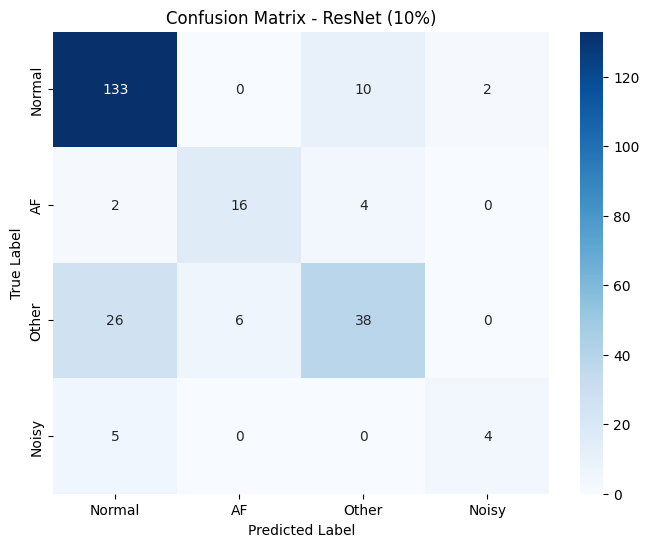

ResNet model saved as: resnet_model_10pct.keras
✅ Completed ResNet training for 10% dataset

PROCESSING 25% DATASET WITH RESNET

TRAINING RESNET ON 25% REDUCED DATASET
Applying augmentation with factor 2...
Original dataset size: 1543
Augmented dataset size: 3086
Augmentation factor achieved: 2.0x
Using augmented dataset for training

Dataset split:
  Training samples: 2468
  Validation samples: 618
Preprocessing ECG data...
Number of training samples: 2468
Number of validation samples: 618
------------------------------
Shape of X_train after padding and reshape: (2468, 8000, 1)
Shape of X_val after padding and reshape: (618, 8000, 1)
------------------------------
Shape of y_train_encoded: (2468, 4)
Shape of y_val_encoded: (618, 4)

Sample of original labels: [2 0 3 2 0]
Sample of one-hot encoded labels:
 [[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]

Input shape for models: (8000, 1)

🔧 Training ResNet Model for 50 epochs...

TRAINING RESNET (25%)
Initi

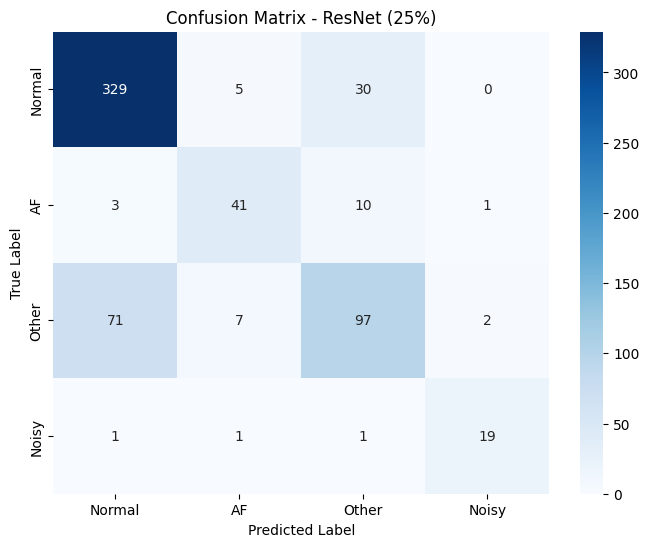

ResNet model saved as: resnet_model_25pct.keras

📝 Generating test predictions for 25% reduced dataset...
Loading and preprocessing test data...
Test data preprocessed. Shape: (2649, 8000, 1)
Loading model and generating predictions...
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Predictions generated for 2649 test samples
Creating submission file...
Predictions saved to 'reduced.csv'

📈 PREDICTION STATISTICS:
Total predictions: 2649
Class distribution:
  Class 0 (Normal): 1737 samples (65.6%)
  Class 1 (AF): 293 samples (11.1%)
  Class 2 (Other): 522 samples (19.7%)
  Class 3 (Noisy): 97 samples (3.7%)
✅ Completed ResNet training for 25% dataset

PROCESSING 50% DATASET WITH RESNET

TRAINING RESNET ON 50% REDUCED DATASET
Applying augmentation with factor 2...
Predictions generated for 2649 test samples
Creating submission file...
Predictions saved to 'reduced.csv'

📈 PREDICTION STATISTICS:
Total predictions: 2649
Class distribution:
  Class 0 (Normal)

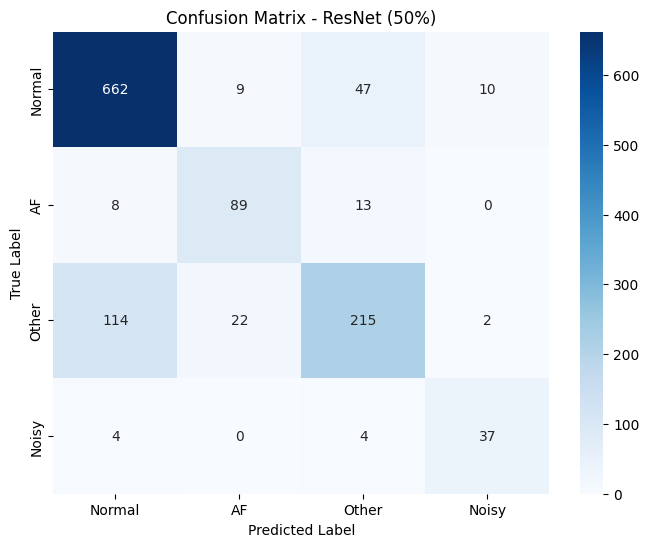

ResNet model saved as: resnet_model_50pct.keras
✅ Completed ResNet training for 50% dataset

PROCESSING 100% DATASET WITH RESNET

TRAINING RESNET ON 100% REDUCED DATASET
Using original dataset (no augmentation)

Dataset split:
  Training samples: 4943
  Validation samples: 1236
Preprocessing ECG data...
Number of training samples: 4943
Number of validation samples: 1236
------------------------------
Shape of X_train after padding and reshape: (4943, 8000, 1)
Shape of X_val after padding and reshape: (1236, 8000, 1)
------------------------------
Shape of y_train_encoded: (4943, 4)
Shape of y_val_encoded: (1236, 4)

Sample of original labels: [0 2 0 0 2]
Sample of one-hot encoded labels:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Input shape for models: (8000, 1)

🔧 Training ResNet Model for 50 epochs...

TRAINING RESNET (100%)
Initial learning rate: 0.001
Starting training for the ResNet (100%)...
Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 

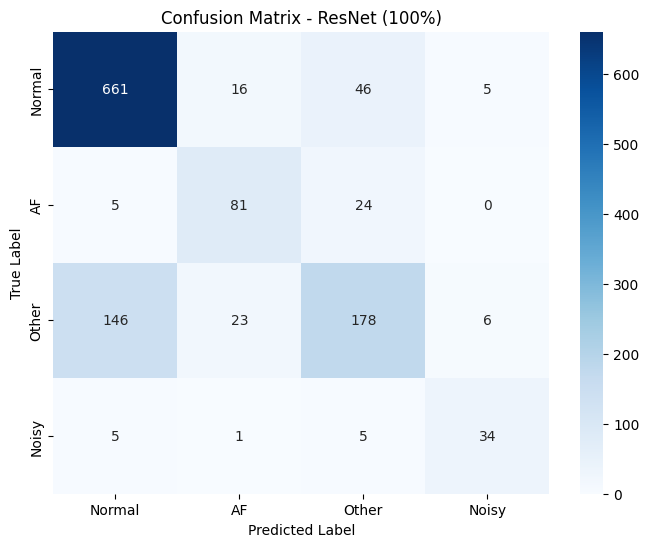

ResNet model saved as: resnet_model_100pct.keras
✅ Completed ResNet training for 100% dataset

RESNET TRAINING COMPLETE!

📊 RESNET TRAINING SUMMARY:
 Model  Dataset_Size_Pct  Original_Samples  Augmented_Samples  Validation_Accuracy  Parameters
ResNet                10               615               1230             0.776423      251908
ResNet                25              1543               3086             0.786408      251908
ResNet                50              3088               6176             0.811489      251908
ResNet               100              6179               6179             0.771845      251908

💾 ResNet training summary saved to 'resnet_training_summary.csv'

📁 Generated Files:
  • reduced.csv (test predictions from 25% dataset)
  • resnet_training_summary.csv (comprehensive results)
  • resnet_model_*.keras (trained ResNet models)


In [8]:
# Comprehensive training on all reduced datasets - ResNet only
print("🚀 Starting comprehensive ResNet training on all reduced datasets...")
print("This may take some time depending on your hardware.")

# Initialize results storage
all_training_results = {}
training_summary = []

# Train on each reduced dataset
dataset_ratios = [0.10, 0.25, 0.50, 1.0]  # Include 100% for comparison

for ratio in dataset_ratios:
    print(f"\n" + "="*80)
    print(f"PROCESSING {int(ratio*100)}% DATASET WITH RESNET")
    print(f"="*80)
    
    # Get the appropriate dataset
    if ratio in reduced_datasets:
        X_data = reduced_datasets[ratio]['X']
        y_data = reduced_datasets[ratio]['y']
    else:
        print(f"Dataset ratio {ratio} not found in reduced_datasets!")
        continue
    
    # Train ResNet model on this dataset
    try:
        results = train_resnet_on_reduced_dataset(
            dataset_ratio=ratio,
            X_data=X_data,
            y_data=y_data,
            X_test_data=X_test_full,
            apply_augmentation=True,
            augmentation_factor=2  # 2x augmentation
        )
        
        # Store results
        all_training_results.update(results)
        
        # Add to summary
        for model_key, model_results in results.items():
            if 'test_predictions' not in model_key:  # Skip test prediction entries
                training_summary.append({
                    'Model': model_results['model_type'],
                    'Dataset_Size_Pct': int(ratio * 100),
                    'Original_Samples': model_results['dataset_size'],
                    'Augmented_Samples': model_results['augmented_size'],
                    'Validation_Accuracy': model_results['accuracy'],
                    'Parameters': model_results['parameters']
                })
        
        print(f"✅ Completed ResNet training for {int(ratio*100)}% dataset")
        
    except Exception as e:
        print(f"❌ Error training ResNet on {int(ratio*100)}% dataset: {str(e)}")
        continue

print("\n" + "="*80)
print("RESNET TRAINING COMPLETE!")
print("="*80)

# Create summary DataFrame
import pandas as pd
summary_df = pd.DataFrame(training_summary)
print("\n📊 RESNET TRAINING SUMMARY:")
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv('resnet_training_summary.csv', index=False)
print(f"\n💾 ResNet training summary saved to 'resnet_training_summary.csv'")

print(f"\n📁 Generated Files:")
print(f"  • reduced.csv (test predictions from 25% dataset)")
print(f"  • resnet_training_summary.csv (comprehensive results)")
print(f"  • resnet_model_*.keras (trained ResNet models)")

📈 Creating ResNet-focused visualizations...


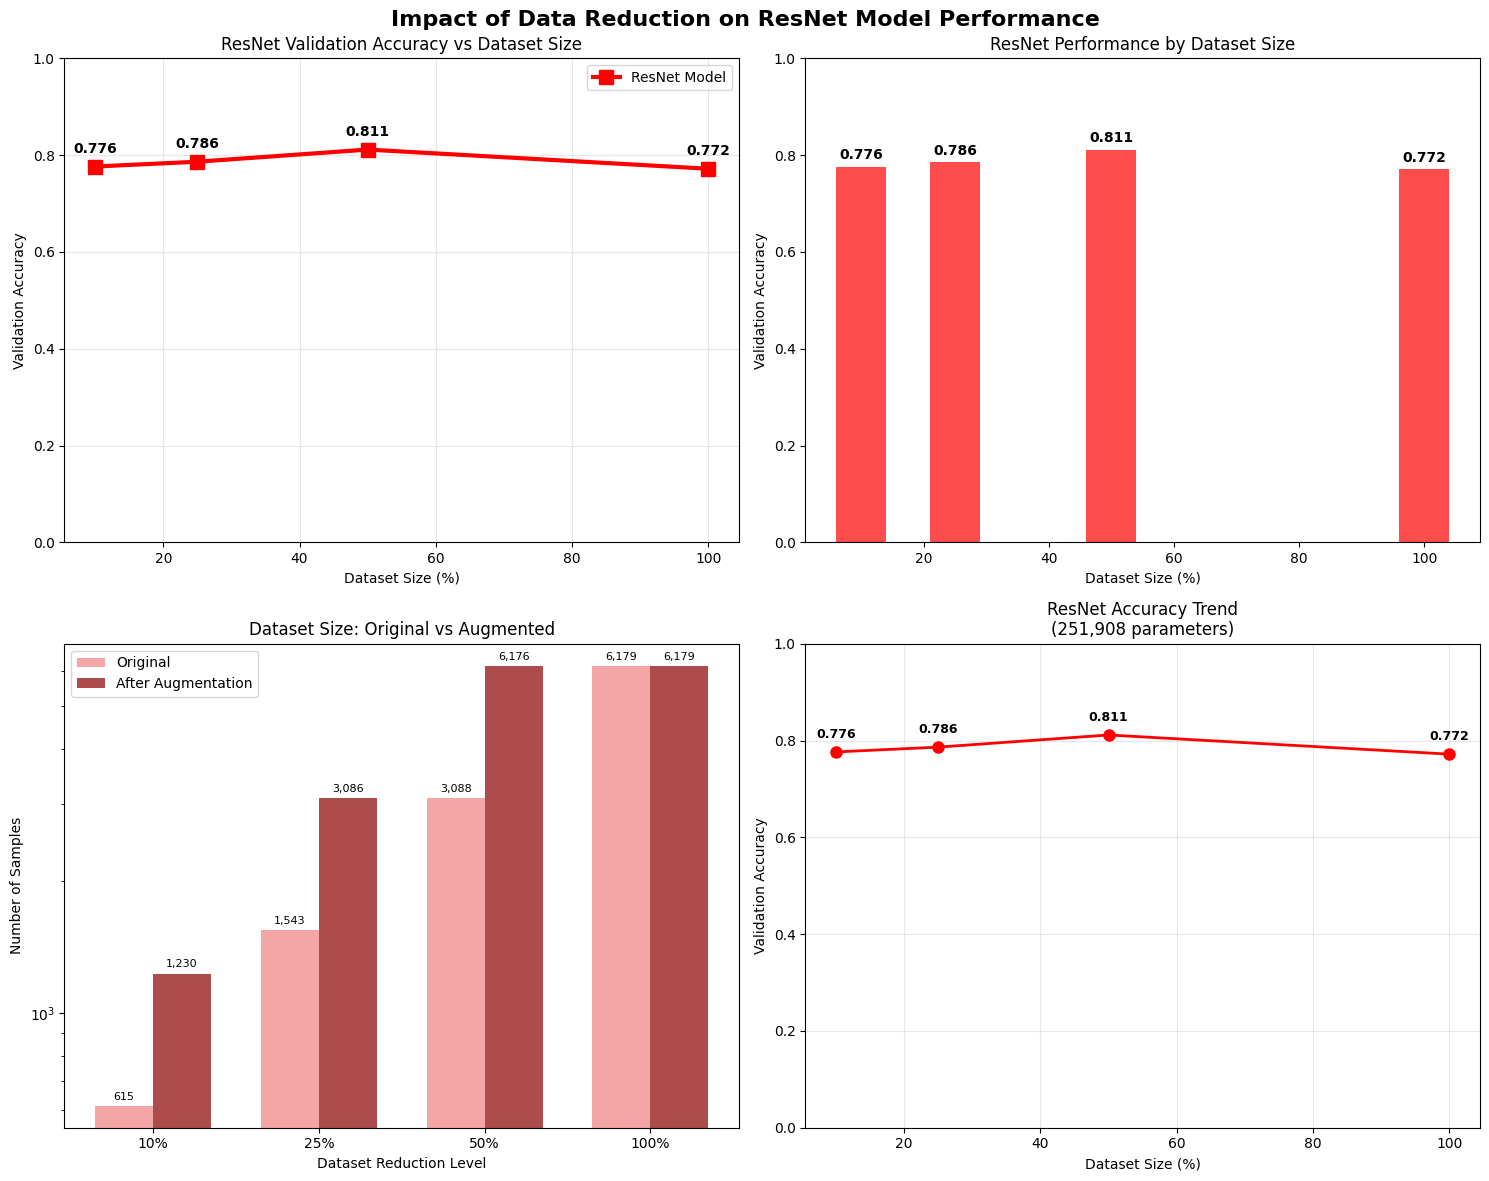


📋 RESNET PERFORMANCE ANALYSIS:

ResNet Validation Accuracy by Dataset Size:
 Dataset_Size_Pct  Validation_Accuracy  Original_Samples  Augmented_Samples
               10             0.776423               615               1230
               25             0.786408              1543               3086
               50             0.811489              3088               6176
              100             0.771845              6179               6179

🔍 RESNET EFFICIENCY ANALYSIS:
Dataset Size    Accuracy        Original Samples   Augmented Samples   
----------------------------------------------------------------------
10%             0.7764          615         1,230
25%             0.7864          1,543         3,086
50%             0.8115          3,088         6,176
100%             0.7718          6,179         6,179

💡 RESNET DATA REDUCTION INSIGHTS:
----------------------------------------
10% → 25%: +1.00 percentage points accuracy gain
25% → 50%: +2.51 percentage points ac

In [9]:
# Results Visualization and Analysis - ResNet Focus
print("📈 Creating ResNet-focused visualizations...")

# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Data Reduction on ResNet Model Performance', fontsize=16, fontweight='bold')

# Plot 1: Accuracy vs Dataset Size
ax1 = axes[0, 0]
resnet_data = summary_df[summary_df['Model'] == 'ResNet']

ax1.plot(resnet_data['Dataset_Size_Pct'], resnet_data['Validation_Accuracy'], 
         marker='s', linewidth=3, markersize=10, label='ResNet Model', color='red')

ax1.set_xlabel('Dataset Size (%)')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('ResNet Validation Accuracy vs Dataset Size')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add value annotations
for _, row in resnet_data.iterrows():
    ax1.annotate(f'{row["Validation_Accuracy"]:.3f}', 
                (row['Dataset_Size_Pct'], row['Validation_Accuracy']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

# Plot 2: Training Progress (if we have history data)
ax2 = axes[0, 1]
# For now, show dataset size vs accuracy as a bar chart
bars = ax2.bar(resnet_data['Dataset_Size_Pct'], resnet_data['Validation_Accuracy'], 
               color='red', alpha=0.7, width=8)
ax2.set_xlabel('Dataset Size (%)')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('ResNet Performance by Dataset Size')
ax2.set_ylim(0, 1)

# Add value annotations on bars
for bar, _, row in zip(bars, range(len(resnet_data)), resnet_data.itertuples()):
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# Plot 3: Dataset Size Impact
ax3 = axes[1, 0]
dataset_sizes = resnet_data['Original_Samples'].values
augmented_sizes = resnet_data['Augmented_Samples'].values
dataset_pcts = resnet_data['Dataset_Size_Pct'].values

width = 0.35
x = np.arange(len(dataset_pcts))

bars1 = ax3.bar(x - width/2, dataset_sizes, width, label='Original', alpha=0.7, color='lightcoral')
bars2 = ax3.bar(x + width/2, augmented_sizes, width, label='After Augmentation', alpha=0.7, color='darkred')

ax3.set_xlabel('Dataset Reduction Level')
ax3.set_ylabel('Number of Samples')
ax3.set_title('Dataset Size: Original vs Augmented')
ax3.set_xticks(x)
ax3.set_xticklabels([f'{int(pct)}%' for pct in dataset_pcts])
ax3.legend()
ax3.set_yscale('log')

# Add value annotations
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Plot 4: Accuracy vs Parameters Trade-off
ax4 = axes[1, 1]
if len(resnet_data) > 1:
    # Show accuracy improvement from smallest to largest dataset
    resnet_accs = resnet_data['Validation_Accuracy'].values
    resnet_params = resnet_data['Parameters'].iloc[0] if len(resnet_data) > 0 else 0
    
    # Show accuracy trend
    ax4.plot(dataset_pcts, resnet_accs, marker='o', linewidth=2, markersize=8, color='red')
    ax4.set_xlabel('Dataset Size (%)')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title(f'ResNet Accuracy Trend\n({resnet_params:,} parameters)')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1)
    
    # Add annotations
    for pct, acc in zip(dataset_pcts, resnet_accs):
        ax4.annotate(f'{acc:.3f}', (pct, acc),
                    textcoords="offset points", xytext=(0,10), 
                    ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Create a detailed performance table
print("\n📋 RESNET PERFORMANCE ANALYSIS:")
print("="*80)

print("\nResNet Validation Accuracy by Dataset Size:")
resnet_performance = resnet_data[['Dataset_Size_Pct', 'Validation_Accuracy', 'Original_Samples', 'Augmented_Samples']]
print(resnet_performance.to_string(index=False))

# Calculate efficiency metrics
print(f"\n🔍 RESNET EFFICIENCY ANALYSIS:")
print(f"{'Dataset Size':<15} {'Accuracy':<15} {'Original Samples':<18} {'Augmented Samples':<20}")
print("-" * 70)

for _, row in resnet_data.iterrows():
    print(f"{int(row['Dataset_Size_Pct'])}%{'':<12} {row['Validation_Accuracy']:.4f}{'':<9} {row['Original_Samples']:,}{'':<8} {row['Augmented_Samples']:,}")

# Data reduction effectiveness analysis
print(f"\n💡 RESNET DATA REDUCTION INSIGHTS:")
print("-" * 40)

if len(resnet_data) > 1:
    # Compare different dataset sizes
    resnet_sorted = resnet_data.sort_values('Dataset_Size_Pct')
    
    for i in range(len(resnet_sorted) - 1):
        current_row = resnet_sorted.iloc[i]
        next_row = resnet_sorted.iloc[i + 1]
        
        current_acc = current_row['Validation_Accuracy']
        next_acc = next_row['Validation_Accuracy']
        current_size = current_row['Dataset_Size_Pct']
        next_size = next_row['Dataset_Size_Pct']
        
        acc_gain = (next_acc - current_acc) * 100
        size_increase = next_size - current_size
        
        print(f"{int(current_size)}% → {int(next_size)}%: {acc_gain:+.2f} percentage points accuracy gain")
    
    # Overall comparison
    min_acc = resnet_sorted['Validation_Accuracy'].iloc[0]
    max_acc = resnet_sorted['Validation_Accuracy'].iloc[-1]
    min_size = resnet_sorted['Dataset_Size_Pct'].iloc[0]
    max_size = resnet_sorted['Dataset_Size_Pct'].iloc[-1]
    
    total_acc_gain = (max_acc - min_acc) * 100
    total_size_increase = max_size - min_size
    
    print(f"\nOverall: {int(min_size)}% → {int(max_size)}% dataset increases accuracy by {total_acc_gain:.2f} percentage points")

print(f"\n✅ ResNet analysis complete! Check the generated files for detailed results.")

In [10]:
# Final Summary and File Overview - ResNet Focus
print("🎯 DATA REDUCTION EXPERIMENT SUMMARY - RESNET MODEL")
print("="*65)

print(f"\n📊 Datasets Created:")
print(f"  • 10% reduced dataset: {len(reduced_datasets[0.10]['X']):,} samples")
print(f"  • 25% reduced dataset: {len(reduced_datasets[0.25]['X']):,} samples") 
print(f"  • 50% reduced dataset: {len(reduced_datasets[0.50]['X']):,} samples")
print(f"  • 100% original dataset: {len(reduced_datasets[1.0]['X']):,} samples")

print(f"\n🤖 Model Trained:")
print(f"  • ResNet 1D model on all 4 datasets")
print(f"  • Training epochs: 50 per dataset")
print(f"  • Total models trained: 4")

print(f"\n🔄 Augmentation Applied:")
print(f"  • 2x augmentation factor on reduced datasets (10%, 25%, 50%)")
print(f"  • Techniques: Noise, Shift, Amplitude scaling, Time stretching, Frequency masking")
print(f"  • No augmentation on 100% dataset (already large enough)")

print(f"\n📁 Generated Files:")
generated_files = []

# Check for generated files
import glob
for pattern in ['*.csv', 'resnet_model_*.keras', 'reduced_data/*.pkl']:
    files = glob.glob(pattern)
    generated_files.extend(files)

for file in sorted(generated_files):
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / (1024 * 1024)
        print(f"  • {file} ({size_mb:.2f} MB)")

🎯 DATA REDUCTION EXPERIMENT SUMMARY - RESNET MODEL

📊 Datasets Created:
  • 10% reduced dataset: 615 samples
  • 25% reduced dataset: 1,543 samples
  • 50% reduced dataset: 3,088 samples
  • 100% original dataset: 6,179 samples

🤖 Model Trained:
  • ResNet 1D model on all 4 datasets
  • Training epochs: 50 per dataset
  • Total models trained: 4

🔄 Augmentation Applied:
  • 2x augmentation factor on reduced datasets (10%, 25%, 50%)
  • Techniques: Noise, Shift, Amplitude scaling, Time stretching, Frequency masking
  • No augmentation on 100% dataset (already large enough)

📁 Generated Files:
  • reduced.csv (0.02 MB)
  • reduced_data/reduced_10pct.pkl (23.18 MB)
  • reduced_data/reduced_25pct.pkl (57.93 MB)
  • reduced_data/reduced_50pct.pkl (114.90 MB)
  • resnet_model_100pct.keras (3.10 MB)
  • resnet_model_10pct.keras (3.10 MB)
  • resnet_model_25pct.keras (3.10 MB)
  • resnet_model_50pct.keras (3.10 MB)
  • resnet_training_summary.csv (0.00 MB)


ResNet Training Summary for 50% Reduced Dataset
Original samples: 3088
Augmented samples: 6176
Validation accuracy: 0.8115
Parameters: 251908


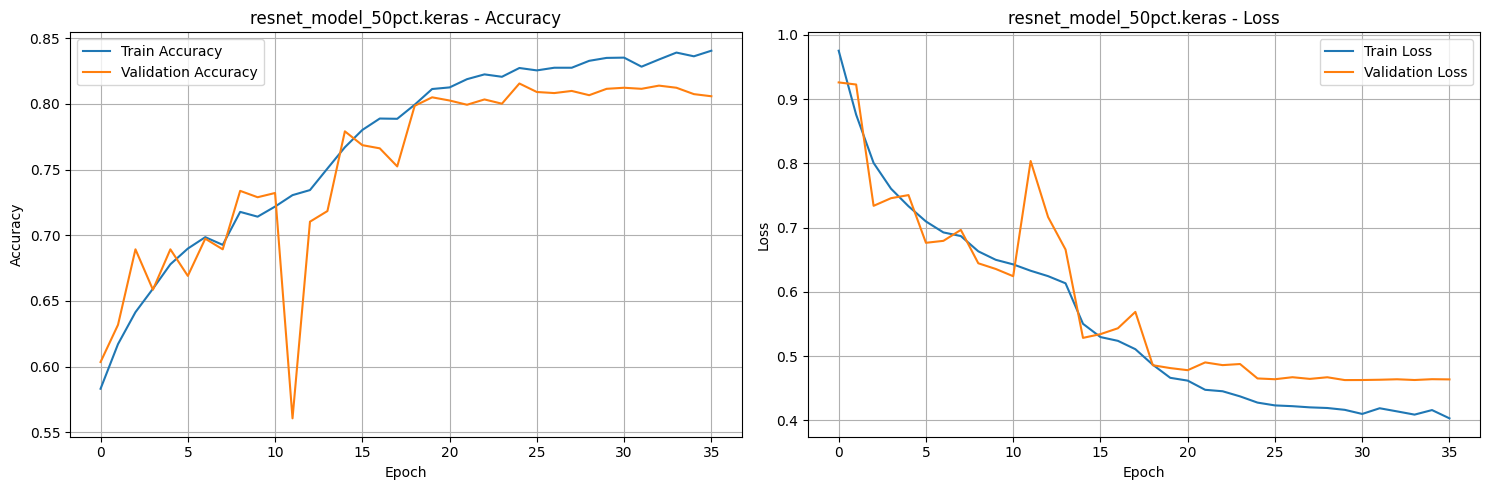

In [15]:
# Create training summary for the 50% reduced dataset using plot_history_with_lr from utils.py

# Get the training results for the 50% reduced dataset
resnet_50pct_results = all_training_results['resnet_50pct']
history_50pct = resnet_50pct_results['history']

print("ResNet Training Summary for 50% Reduced Dataset")
print("="*50)
print(f"Original samples: {resnet_50pct_results['dataset_size']}")
print(f"Augmented samples: {resnet_50pct_results['augmented_size']}")
print(f"Validation accuracy: {resnet_50pct_results['accuracy']:.4f}")
print(f"Parameters: {resnet_50pct_results['parameters']}")

# Plot training history with learning rate
utils.plot_history_with_lr(history_50pct, "resnet_model_50pct.keras")